In [91]:
%cd 'C:\\Users\\Michael\\Documents\\Boston University\\2016 - Spring\\CS 591\\course-2016-spr-proj-one'
%matplotlib inline

C:\Users\Michael\Documents\Boston University\2016 - Spring\CS 591\course-2016-spr-proj-one


In [3]:
import pandas
from mjclawar_rarshad.tools import pandas_funcs

In [127]:
import json
import pymongo
import numpy as np
import pandas

from mjclawar_rarshad.sources import crime, property_assessment, boston_public_schools, hospital_locations
from mjclawar_rarshad.tools import bdp_query, database_helpers, pandas_funcs

from sklearn import cluster
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

In [6]:
exec(open('pymongo_dm.py').read())

In [9]:
with open('mjclawar_rarshad/auth.json', 'r') as f:
    auth_json = json.load(f)
    api_token = auth_json['api_token']
    username = auth_json['username']
    mongo_pass = auth_json['pass']

database_helper = database_helpers.DatabaseHelper(username=username, password=mongo_pass)
bdp_api = bdp_query.BDPQuery(api_token=api_token)

In [87]:
df = pandas_funcs.read_mongo_collection('mjclawar_rarshad.crime_incidents', database_helper)

In [88]:
df.head()

,_id,day_week,domestic,fromdate,location,month,naturecode,shooting,weapontype,year
0,56c11e4cd2230fbde4f27a64,Monday,No,2015-08-10T05:20:00,"{'needs_recoding': False, 'longitude': '0.0', ...",8,MVA,No,None,2015
1,56c11e4cd2230fbde4f27a65,Monday,No,2015-08-10T05:01:00,"{'needs_recoding': False, 'longitude': '0.0', ...",8,CD19,No,None,2015
2,56c11e4cd2230fbde4f27a66,Monday,No,2015-08-10T04:48:00,"{'needs_recoding': False, 'longitude': '0.0', ...",8,MVA,No,None,2015
3,56c11e4cd2230fbde4f27a67,Monday,No,2015-08-10T04:46:00,"{'needs_recoding': False, 'longitude': '0.0', ...",8,ARREST,No,None,2015
4,56c11e4cd2230fbde4f27a68,Monday,No,2015-08-10T02:38:00,"{'needs_recoding': False, 'longitude': '0.0', ...",8,MVA,No,None,2015


In [89]:
df = df.merge(df['location'].apply(lambda x: pandas.Series({'NEEDS_RECODE': x['needs_recoding'], 'LONGITUDE': float(x['longitude']), 'LATITUDE': float(x['latitude'])})), 
    left_index=True, right_index=True)

In [170]:
def spherical_dist(pos1, pos2, r=3958.75):
    pos1 = pos1 * np.pi / 180
    pos2 = pos2 * np.pi / 180
    cos_lat1 = np.cos(pos1[..., 0])
    cos_lat2 = np.cos(pos2[..., 0])
    cos_lat_d = np.cos(pos1[..., 0] - pos2[..., 0])
    cos_lon_d = np.cos(pos1[..., 1] - pos2[..., 1])
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))

In [171]:
def sse_group (df):
    sse = np.sum(spherical_dist(df[['LONGITUDE', 'LATITUDE']].values, np.array([df[['LONGITUDE', 'LATITUDE']].mean().values])) ** 2)
    return sse

In [176]:
# Initialize KMeans object with k clusters
k_range = range(2, 15)

df_temp = df[df['LONGITUDE'] != 0]
n = len(df_temp)
bic_last = -np.inf

for k in k_range:
    clust = cluster.KMeans(n_clusters=k, random_state=1)
    preds = clust.fit_predict(df_temp[['LONGITUDE', 'LATITUDE']])
    clust_centers = clust.cluster_centers_
    sse = df_temp[['LONGITUDE', 'LATITUDE']].groupby(preds).apply(sse_group).sum()
    bic = n * np.log(sse / n) + k * np.log(n)
    pct_improve = (bic - bic_last) / bic_last
    print(bic, pct_improve, sse)
    if pct_improve < .01:
        print(k)
        break
    bic_last = bic

print(preds)

1094.26697453 nan 3106.44449817
414.465259148 -0.621239360416 1299.94565759
3
[1 2 0 2 2 2 1 2 2 2 2 2 2 0 2 2 1 1 0 0 2 2 2 0 2 0 0 1 2 1 2 0 0 2 2 2 1
 0 0 2 1 2 2 2 0 0 2 2 0 0 1 1 2 0 0 2 2 2 2 2 2 2 2 2 1 2 1 1 1 0 2 2 2 2
 2 1 0 0 0 0 1 0 0 0 0 0 2 1 2 2 2 2 1 2 0 0 2 2 1 2 2 2 2 2 1 1 0 2 0 1 2
 2 0 2 0 2 2 0 1 0 0 0 2 2 1 1 0 0 2 2 2 2 2 1 2 0 2 1 2 0 0 2 2 0 2 2 2 2
 0 0 2 1 0 0 1 0 0 2 2 0 1 2 0 1 1 2 0 0 1 2 0 2 0 1 0 1 1 0 2 0 2 0 2 0 0
 2 2 1 2 0 1 2 0 2 0 1 0 0 0 2 2 2 0 1 0 0 1 1 2 0 2 0 0 0 0 2 0 0 0 1 0 2
 2 0 2 0 2 2 0 0 2 0 0 0 2 2 0 1 2 2 0 1 2 0 2 1 1 2 0 2 0 1 1 2 0 2 0 2 2
 2 2 0 2 2 2 0 1 0 2 2 2 1 2 1 1 2 1 0 0 2 0 2 1 1 2 1 2 0 0 0 0 2 1 0 0 2
 2 0 0 2 0 2 2 2 0 0 0 2 1 1 1 0 1 1 0 2 0 2 2 2 0 2 0 1 2 2 2 2 0 0 1 2 2
 0 2 2 1 1 1 0 1 2 2 1 1 1 0 0 2 0 2 0 2 2 0 0 1 1 2 1 2 0 1 0 1 0 0 0 2 2
 2 1 0 2 0 2 0 0 2 1 0 2 0 1 2 0 2 0 0 0 1 0 1 1 0 1 0 0 1 0 2 2 1 1 0 1 0
 2 2 2 1 1 2 0 0 2 0 2 2 2 1 2 2 2 0 0 1 1 0 2 1 2 2 1 2 0 0 2 0 0 0 2 0 1
 2 2 2 0 2 2 0 1 1 2 1

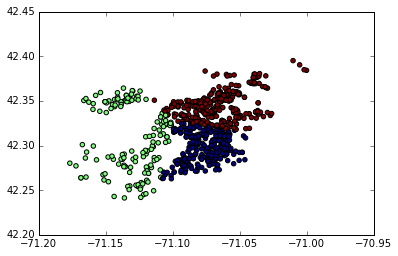

In [175]:
plt.scatter(df_temp['LONGITUDE'], df_temp['LATITUDE'], c=preds)

In [50]:
clust.fit(df[['av_total', 'living_area']].astype(np.float64).dropna())

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [52]:
clust.predict(df[['av_total', 'living_area']].astype(np.float64).dropna())

array([5, 5, 5, 1, 1, 5, 1, 5, 5, 1, 5, 7, 7, 7, 0, 7, 7, 7, 0, 5, 5, 7, 7,
       7, 0, 5, 5, 5, 7, 7, 7, 0, 5, 5, 0, 5, 7, 7, 7, 0, 1, 1, 1, 7, 7, 7,
       7, 7, 7, 0, 1, 5, 7, 7, 7, 0, 5, 1, 5, 5, 1, 1, 5, 1, 1, 1, 0, 0, 7,
       7, 7, 0, 7, 7, 7, 0, 5, 1, 1, 0, 0, 6, 3, 2, 0, 1, 5, 5, 1, 5, 5, 5,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       0, 7, 7, 7, 0, 5, 5, 5, 5, 5, 5, 5, 3, 6, 7, 1, 1, 1, 1, 1, 1, 7, 7,
       0, 1, 7, 5, 7, 1, 1, 7, 1, 1, 5, 1, 1, 1, 0, 1, 5, 1, 1, 0, 0, 5, 1,
       1, 0, 7, 7, 7, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1,
       0, 7, 1, 1, 5, 6, 1, 1, 1, 1, 1, 7, 7, 7, 0, 1, 1, 1, 1, 5, 1, 5, 5,
       5, 1, 1, 1, 5, 1, 7, 1, 1, 7, 1, 1, 5, 1, 1, 1, 0, 5, 5, 1, 5, 1, 1,
       7, 1, 1, 7, 1, 1, 1, 1, 7, 7, 7, 0, 1, 1, 6, 5, 1, 5, 5, 7, 7, 7, 0,
       5, 1, 5, 5, 1, 5, 1, 1, 5, 5, 0, 0, 1, 7, 7, 7, 0, 7, 7, 7, 0, 3, 6,
       5, 5, 5, 5, 7, 7, 7, 0, 7, 7, 7, 0, 5, 6, 1, 1, 1, 0, 1, 1, 1, 0, 5,
       1, 1,